### Innledning

Utslipp av plast i havet er et stort miljøproblem både nasjonalt og internasjonalt og fører blant annet til forurensing av kystlinjer og skader på fugl og fisk. Det å kunne beregne hvor og når utslipp av plast i havet kan ende opp kan være nyttig, siden det kan forenkle opprydding. Beregningen kan også gi et grunnlag for å vurdere miljøkonsekvenser av utslipp.

En plastbits posisjon som funksjon av tiden vil være avhengig av både startposisjon samt strømninger i luft og hav og plastbitens høyde i vannet. Dermed er det mulig å beskrive plastbitens posisjonsendring med en differensialligning, som kan løses numerisk. Bevegelsen til et stort antall plastpartikler kan tilnærmes med å simulere et langt mindre antall partikler.

Utførte beregninger tyder på at en samling partikler som begynner nær hverandre vil kunne spres i løpet av få dager og at hvor høyt partiklene flyter i vannet vil avgjøre hvor fort partiklene strander på land.

### Utlevert kode

In [24]:
#Felles kode som behøves for å kjøre
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from time import time

# Functions for plotting on map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# This can be useful, install with
# conda install line_profiler
%load_ext line_profiler
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from scipy.stats import linregress
from time import perf_counter
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        #sjekker om man er på land, sjekker om punktet er land
        land = self.on_land(X)
        #Om punktet er på land er hastigheten 0
        dx = np.where(land, 0, dx)
        dy = np.where(land, 0, dy)
        return np.array([dx, dy])
    
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('./data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Oppgave 1a

Heuns metode er implementert nedenfor i henhold til prosjektbeskrivelsen.

In [25]:
def heun_step(x_i, t_i, h, f):
    #definerer et heun-steg som i prosjektbeskrivelsen
    k1 = f(x_i, t_i)
    #bruker k1 for å beregne k2
    k2 = f(x_i + k1*h, t_i + h)
    #neste x-verdi definert ved hjelp av k1 og k2
    x_i1 = x_i + h*(k1 + k2)/2
    return x_i1

def heun_method(x_0, t_0, t_end, h, f):
    #bruker heun-steg for å løse en diff-ligning f
    n = int((t_end-t_0)/h)
    #x_i er et array med m punkter [x, y], dermed har resultatet dim nx2xm
    #siden man har n punkter i tiden
    res = np.zeros((n, x_0.shape[0], x_0.shape[1]))
    res[0] = x_0
    for i in range(1, n):
        #finner neste punkt som funksjon av det forrige
        res[i] = heun_step(res[i-1], t_0+i*h, h, f)
    return res

Den analytiske diffligningen brukt i oppgave 1 er implementert nedenfor i henhold til prosjektbeskrivelsen.

In [26]:
def analytic(x_i, t_i):
    #definerer konstanter
    A = 0.1
    epsilon = 0.25
    omega = 1
    #hjelpefunksjon a(t)
    def a(t):
        return epsilon*np.sin(omega*t)
    #hjelpefunksjon b(t)
    def b(t):
        return 1 - 2*epsilon*np.sin(omega*t)
    #hjelpefunksjon f(x, t)
    def f(x, t):
        return a(t)*x**2+b(t)*x 
    #den deriverte av f med hensyn på x
    def df(x, t):
        return 2*a(t)*x + b(t)
    #beregner dx og dy ved hjelp av hjelpefunksjonene
    dx = -np.pi*A*np.sin(np.pi*f(x_i[0], t_i))*np.cos(np.pi*x_i[1]) 
    dy = np.pi*A*np.cos(np.pi*f(x_i[0], t_i))*np.sin(np.pi*x_i[1])*df(x_i[0], t_i) 
    #returnerer resultatarray
    return np.array([dx, dy])

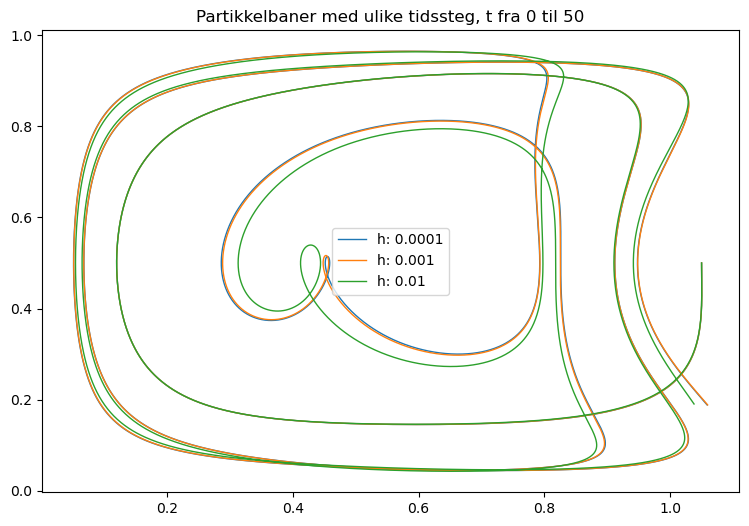

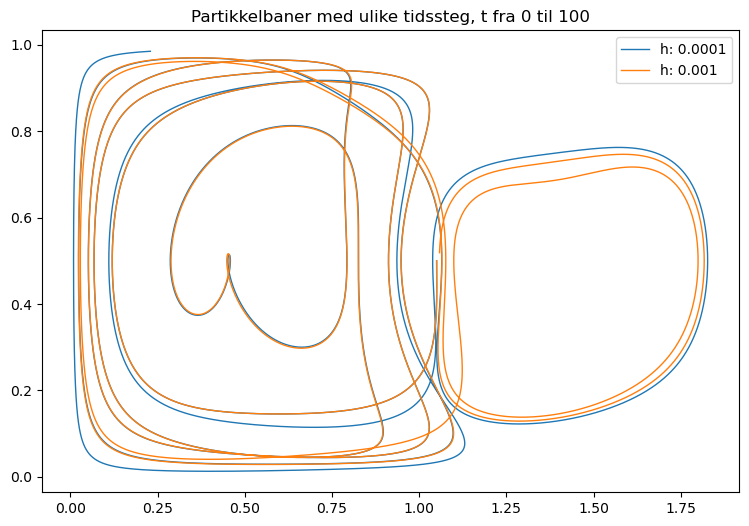

In [8]:
def oppgave_1_a(t_end, h_arr):
    #initiell posisjon
    X = np.array([[1.05], [0.5]])
    t_0 = 0
    Solution_arr = []
    #kalkuler ruten med forskjellige tidssteg
    for h in h_arr:
        Solution_arr.append(heun_method(x_0=X, t_0 = t_0, t_end = t_end, h = h, f = analytic))
    return Solution_arr

#Plott resultatene
def plot_oppgave_1_a(Solution_arr, h_arr):
    fig = plt.figure(figsize=(9,6))
    ax = plt.axes()
    for j in range(len(Solution_arr)):
        for i in range(Solution_arr[j].shape[2]):
            ax.plot(Solution_arr[j][:,0,i], Solution_arr[j][:,1,i], alpha=1, lw=1, label="h: "+str(h_arr[j]))
    plt.legend()


h_arr=[0.0001, 0.001, 0.01]
plot_oppgave_1_a(oppgave_1_a(50, h_arr), h_arr)
plt.title("Partikkelbaner med ulike tidssteg, t fra 0 til 50")
plt.show()
#Velg fornuftig tidssteg, velger h= 0.001 og sammenligner med 0.0001
h_arr = [0.0001,0.001]


#Doble intervallet og gjenta alt
plot_oppgave_1_a(oppgave_1_a(100, h_arr), h_arr)
plt.title("Partikkelbaner med ulike tidssteg, t fra 0 til 100")
plt.show()

Her er $h$ tidssteget. I det første plottet ser man avstanden mellom linjen for $h = 10^{-2}$ og $h = 10^{-4}$ varierer i størrelse, men er stor på visse punkter. Siden vi vet at $h = 10^{-4}$ er en mer nøyaktig tilnærmelse enn $h = 10^{-2}$ og $h = 10^{-3}$ bruker vi $h = 10^{-4}$ som referanse. Man kan observere at avstanden mellom linjen gitt av $h = 10^{-3}$ og $h = 10^{-4}$ hele tiden er marginal, som betyr at man velger $h = 10^{-3}$ til å være et tilstrekkelig kort tidssteg for $t \in [0, 50]$.

I det andre plottet sammenligner man løsningen beregnet med $h = 10^{-3}$ med løsningen beregnet med $h = 10^{-4}$. For $t \in [0, 50]$ ble det konkludert at disse to tidsstegene ga tilstrekkelig nær løsning, og dermed at $h = 10^{-3}$ er tilstrekkelig liten. Her observeres det at for $t \in [0, 100]$ ender løsningene beregnet med $h = 10^{-3}$ og $h = 10^{-4}$ opp på vidt forskjellige steder, som betyr at $h = 10^{-3}$ ikke er tilstrekkelig liten for $t \in [0, 100]$.

Dette er ikke overraskende, siden en liten feil vil kunne vokse over tid. Om en liten feil vokser over tid, eller om løsningen vil konvergere på tross av en liten feil, er selvfølgelig avhengig av naturen til ligningen som løses, men her er det klart at en liten feil vil føre til at løsningene divergerer over tid.

#### Oppgave 1b

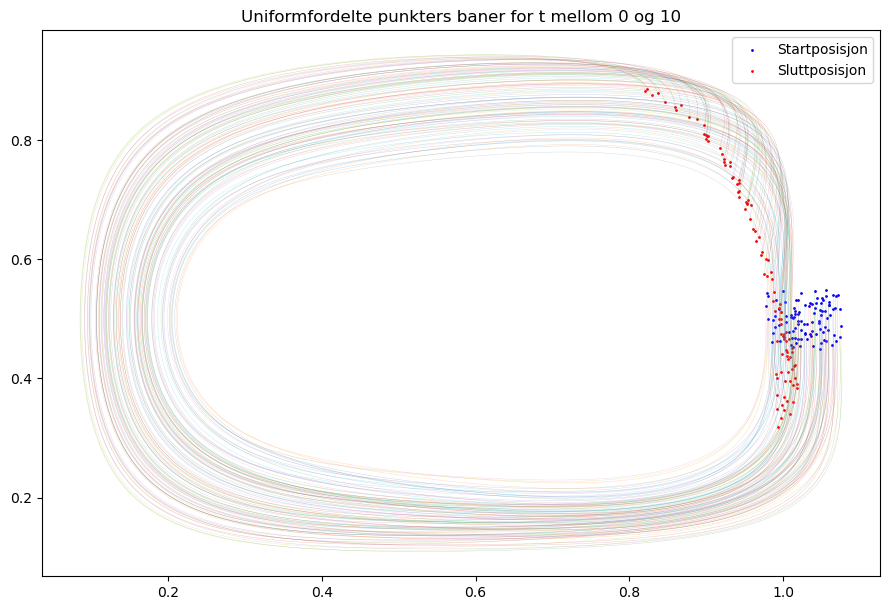

In [9]:
#Initialiserer variable
Np = 100
X = np.zeros((2, Np))
X[0,:] = np.random.uniform(0.975, 1.075, Np)
X[1,:] = np.random.uniform(0.45, 0.55, Np)
h = 10**-4
t_0 = 0
t_end = 10
#Finner numerisk løsning
Solution = heun_method(x_0=X, t_0 = t_0, t_end = t_end, h = h, f = analytic)

fig = plt.figure(figsize=(9,6))
ax = plt.axes()


# scatter plot positions, note the extra transform keyword
ax.scatter(Solution[0,0,:], Solution[0,1,:], s=1,  label='Startposisjon', color='blue')
ax.scatter(Solution[-1,0,:], Solution[-1,1,:], s=1,  label='Sluttposisjon', color='red')

#Plotter alle banene
for i in range(Solution.shape[2]):
    ax.plot(Solution[:,0,i], Solution[:,1,i], alpha=0.3, lw=0.3)

ax.legend()
plt.tight_layout()
plt.title("Uniformfordelte punkters baner for t mellom 0 og 10")
plt.show()

I overstående plott er uniformfordelte startposisjoner ved $t = 0$ innenfor $x \in [0.975, 1.075]$ og $y \in [0.045, 0.055]$ plottet sammen med punktenes posisjon ved $t = 10$ og punktenes bane for $t \in [0, 10]$. Fra plottet kan det observeres at punktene går fra å være plassert i et kvadrat til å blir bregrenset av en lang og smal stripe, hvor maksimal avstand mellom punktene er økt dramatisk. Dette, som i plottene i forrige deloppgavene, viser at selv en liten forskjell i punktenes startposisjon kan føre til en langt større forskjell i deres sluttposisjon. Dette kommer her for eksempel til uttrykk ved at største avstand mellom to punkters startposisjon er under 0.15 mens største avstand mellom to punkters slutposisjon er over 0.5.

#### Oppgave 1c
Deretter så vi på hvordan kjøretiden skalerte som funksjon av antall partikler. Vi forventet at for større verdier av antall partikler ville sammenhengen bli tilnærmet lineær i et loglog-plott, noe vi forklarer årsaken til nedenfor. Vi trengte dermed ikke å plotte like mange punkter for større verdier av antall partikler, hvilket gir mye lengre kjøretid. Vi valgte derfor å plotte $100$ punkter som utgjorde en geometrisk rekke, slik at vi fikk færre punkter ved høyere verdier. Vi valgte også å se på antall partikler $N_p$ fra $1$ til $100 000$, som sammen med kravet om at det skulle være $100$ punkter, gjorde oss i stand til å finne den geometriske faktoren. Annet å bemerke er at verdiene for $N_p$ ikke er heltall. Løsningen vår var å bruke Python-funksjonen *int()* for å få heltallige antall partikler.

Stigningstall = 0.937192279441974, konstantledd = -3.829414856922799


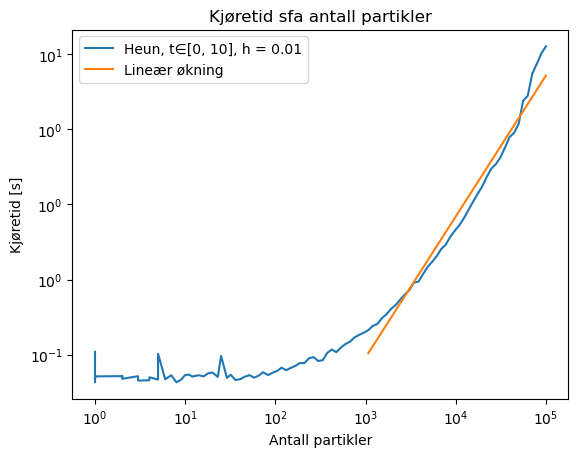

In [10]:
#Variabler
npoints = 100
faktor = np.e**(np.log(10**5)/(npoints-1))
N_p_vals = np.array([int(faktor**i) for i in range(npoints)])
time_vals = np.zeros(N_p_vals.shape)


#tidsvariabler for Heuns metode
t_0 = 0
t_end = 10
h = 0.01

#Beregner kjøretid
for i, N in enumerate(N_p_vals):
    start = perf_counter()
    X_init = np.zeros((2, N))
    X_init[0, :] = np.linspace(0, 0.1, N)
    X_init[1, :] = np.linspace(0, 0.1, N)
    Solution = heun_method(x_0=X_init, t_0 = t_0, t_end = t_end,h = h, f = analytic)
    stop = perf_counter()
    time_vals[i] = stop-start

#Tar logaritmen av verdiene for å plotte i loglog-plot
N_p_vals = np.log10(N_p_vals)
time_vals = np.log10(time_vals)

#plotter
plt.plot(N_p_vals, time_vals, label = "Heun, t∈[0, 10], h = 0.01")

#Lineær regresjon
N_p_vals_lin = N_p_vals[N_p_vals>3]
time_vals_lin = time_vals[N_p_vals>3]
linreg = linregress(N_p_vals_lin, time_vals_lin)
a, b = linreg[0], linreg[1]

#plotter lineær regresjon o
plt.plot(N_p_vals_lin, a * N_p_vals_lin + b, "-", label = "Lineær økning")

#Formaterer plottet
plt.legend()
plt.title("Kjøretid sfa antall partikler")
plt.xlabel("Antall partikler")
plt.ylabel("Kjøretid [s]")
print(f"Stigningstall = {a}, konstantledd = {b}")
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))

plt.show()

I plottet over er den oransje linjen en lineær regresjon av kjøretiden til $N_p$ over $10^3$. Dette er et arbitrært valg og er bare med for bedre å illustrere den lineære sammenhengen for større verdier av $N_p$. Fra plottet ser vi at for små $N_p$ er kjøretiden omtrent konstant, mens for store verdier av $N_p$ blir sammenhengen tilnærmet lineær i et loglog-plott.Årsaken er at vi gjennomgående bruker *NumPy*-arrays og -funksjoner. *NumPy* parallellisere beregninger av Heuns metode i *NumPy*-arrayene. For små verdier av $N_p$ tyder det på at vi er under datamaskinens maksimale evne til å parallellisere beregninger. Dermed blir kjøretiden tilnærmet konstant. For større verdier av $N_p$, derimot, virker det som om vi er over grensen for antall beregninger som kan parallelliseres. For store verdier av $N_p$ er det derfor rimelig å anta at dersom man tidobler antall partikler, bør en tidoble beregningstiden, for eksempel. Over er det printet ut stigningstallet til den lineære regresjonen og den er tilnærmet lik $1$, som støtter antakelsen. 


### Oppgave 2
Deretter skal vi simulere partikkelbevegelse på havet. For å modellere bevegelsen bruker vi følgende bevegelsesligning:
$$ \dot{\vec{x}} = \vec{V_c}(\vec{x}, t) + f_w \vec{V_w}(\vec{x}, t)$$
Her er $\dot{\vec{x}}$ partikkelens hastighetsvektor, $\vec{V_c}(\vec{x}, t)$ hastighetsfeltet til havet og $\vec{V_w}(\vec{x}, t)$ hastighetsfeltet til vinden. Hav- og vindhastigheter hentet vi fra oppgavefilens vedlagte fil, som inneholder målinger av disse to hastighetene over seks dager, fra den 20. mars 2024 til den 25. mars 2024.
Videre er $f_w$ den såkalte *windage*-faktoren, hvilken sier i hvor stor grad vindhastigheten påvirker farten til partikkelen. Denne faktoren vil selvsagt avhenge av geometrien til partikkelen, men i denne oppgaven setter vi denne lik $0,03$. 
For å løse den ovennevnte bevegelsesligningen benytter vi oss av Heuns metode, som er implementert tidligere i dokumentet. Vi simulerte $500$ plastikkpartikler ($N_p = 500$) vil gi i en periode på fem dager og med et tidssteg på $3600s$, det vil si én time. Først plotter vi bevegelsen i et kartesisk koordinatsystem. Vi normalfordeler posisjonen til de 500 partiklene med $\hat{x} = 790 000m$, $490 000m$ og $\sigma = 10 000m$ (for både $x$ og $y$).

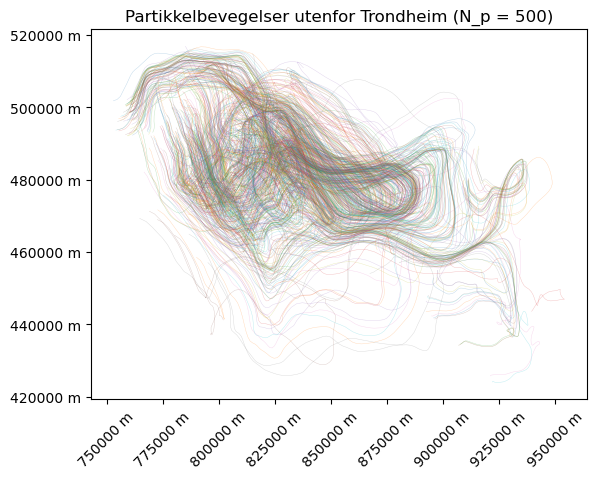

In [27]:
#Lager array med initielle posisjoner
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(790_000, 10_000, N_p)
X[1,:] = np.random.normal(490_000, 10_000, N_p)

#Definerer start- og slutttid og tidssteget
t_0 = 0
t_end = 3600 * 24 * 5
h = 3600

#Løser bevegelsesligningen
Solution = heun_method(X, t_0, t_end, h, f)


#Plotter i xy-plan
for i in range(Solution.shape[2]):
    plt.plot(Solution[:, 0, i], Solution[:, 1, i], alpha=0.3, lw=0.3)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d m'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d m'))
plt.title("Partikkelbevegelser utenfor Trondheim (N_p = 500)")

#plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Grafen over viser partikkelbaner til normalfordelte punkter litt utenfor Trondheim i et kartesisk kordinatsystem.. Vi ser fra banene at det er i høy grad kaotiske og at små endringer i startposisjoner kan gi svært ulike sluttposisjoner. 

Deretter plotter vi bevegelser til partikler utenfor den norske kysten. Siden vi skal lage flere plott, lager vi en virtuell klasse kalt *MapPlot*. Fordelen med denne virtuelle klassen er at vi kan lage flere, spesifikke arvede klasser som har ulike fordelinger. Eksempelvis lager vi *NormalPlot*, som plotter normalfordelte punkter. Implementasjonen er nedenfor.

In [28]:
#Den virtuelle klassen
class MapPlot():
    def __init__(self, N_p, t_0, t_end, h, f) -> None:
        #Variabler alle de arvede klassene benytter
        self.N_p = N_p
        self.t_0 = t_0
        self.t_end = t_end
        self.h = h
        self.f = f
    
    #Lager en "gjemt" funksjon som oppretter egnet figur og akse
    def __make_fig__(self):
        #Lager figur og akse
        self.fig = plt.figure(figsize=(9,6))
        self.ax = plt.axes(projection=ccrs.NorthPolarStereo())

        #Legger til feature
        self.ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

        #Lager projeksjonsobjekt for å konvertere til partikkelposisjoner
        self.npstere = ccrs.Stereographic(
            central_latitude = 90,
            central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
            false_easting = f.dataset.projection_stere.false_easting,
            false_northing = f.dataset.projection_stere.false_northing,
            true_scale_latitude = f.dataset.projection_stere.standard_parallel,
        )
    
    #Plottefunksjonen implementeres i de arvede klassene
    def plot(self):
        raise NotImplemented
        
#Lager normalfordelt plot
class NormalPlot(MapPlot):
    def __init__(self, N_p, t_0, t_end, h, f, x_expected, y_expected, stdx, stdy) -> None:
        self.x_expected = x_expected
        self.y_expected = y_expected
        self.stdx = stdx
        self.stdy = stdy
        super().__init__(N_p, t_0, t_end, h, f)

    def plot(self):
        #Plotter og returnerer figur og akse
        self.__make_fig__()
        self.X = np.zeros((2, self.N_p))
        self.X[0,:] = np.random.normal(self.x_expected, self.stdx, self.N_p)
        self.X[1,:] = np.random.normal(self.y_expected, self.stdy, self.N_p)
        Solution = heun_method(x_0=self.X, t_0=self.t_0, t_end=self.t_end, h=self.h, f=self.f)
        for i in range(Solution.shape[2]):
            self.ax.plot(Solution[:, 0, i], Solution[:, 1, i], transform=self.npstere, alpha=0.3, lw=0.3)

        self.ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )

        return self.fig, self.ax

    

class UniformPlot(MapPlot):
    def __init__(self, N_p, t_0, t_end, h, f, startx, stopx, starty, stopy) -> None:
        self.startx = startx
        self.stopx = stopx
        self.starty = starty
        self.stopy = stopy
        super().__init__(N_p, t_0, t_end, h, f)

    def plot(self):
        #Plotter og returnerer figur og akse
        self.__make_fig__()
        self.X = np.zeros((2, self.N_p))
        self.X[0,:] = np.random.uniform(self.startx, self.stopx, self.N_p)
        self.X[1,:] = np.random.uniform(self.starty, self.stopy, self.N_p)

        Solution = heun_method(x_0=self.X, t_0=self.t_0, t_end=self.t_end, h=self.h, f=self.f)
        #Plotter partikkelbanene
        for i in range(Solution.shape[2]):
            self.ax.plot(Solution[:, 0, i], Solution[:, 1, i], transform=self.npstere, alpha=0.3, lw=0.3)
        
        self.ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )


        return self.fig, self.ax

Først plotter vi samme betingelser som overfor, altså normalfordelte punkter litt utenfor Trondheim. Eneste forskjell er at vi nå plotter banene inn i kartprojeksjonen. 

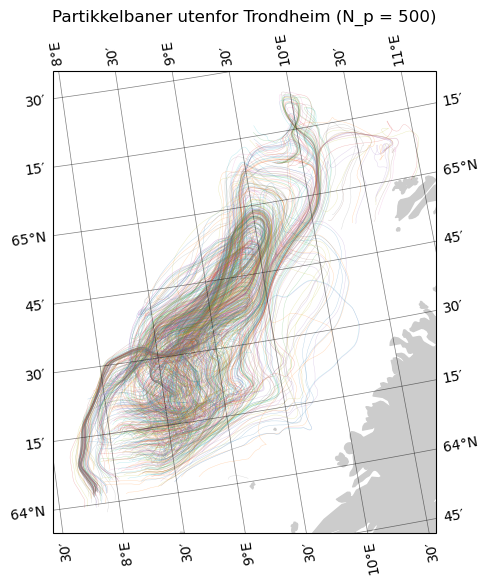

In [29]:
#Plotter
N1 = NormalPlot(N_p = 500, t_0 = 0, t_end =3600*24*5, h= 3600, f = f, x_expected=790_000, y_expected=490_000, stdx=10_000, stdy = 10_000)
fig, ax = N1.plot()
ax.set_title("Partikkelbaner utenfor Trondheim (N_p = 500)")
plt.show()

Vi ser at også her er banene er svært kaotiske og at små variasjoner i startposisjoner kan endre banene og sluttposisjonen fullstendig. 

Deretter vil vi se på bevegelsen til partikler som har normalfordelte startpunkter litt utenfor kysten til Kristiansand. Vi valgte derfor $\hat{x} = 100 000m$ og $\hat{y} = 250 000m$. For ikke å få startpunkter på land satt vi standardavviket til $x$ til å være $1000m$, mens standardavviket til $y$ lot vi fortsatt være $10 000m$.

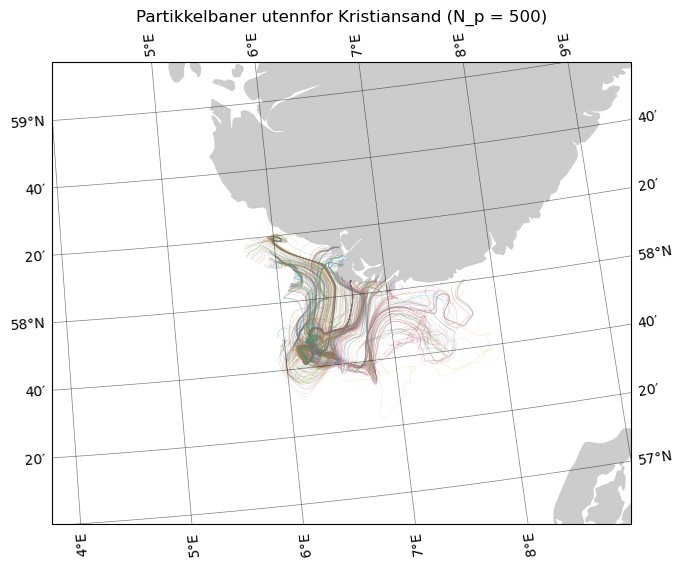

In [30]:
#plotter
N2 = NormalPlot(N_p = 500, t_0 = 0, t_end =3600*24*5, h= 3600, x_expected=100_000, y_expected=250_000, stdx=1_000, stdy = 10_000, f=f)
fig, ax = N2.plot()
ax.set_extent((4, 9, 57, 59))
ax.set_title("Partikkelbaner utennfor Kristiansand (N_p = 500)")
plt.show()

Her ser vi også at små variasjoner fører til vidt forskjellige baner og sluttposisjoner. Her ser vi også at mange av partiklene havnet på land.Ikke desto mindre har de strandete partiklene havnet på vidt forskjellige steder.
Vi ville også se på partikkelbaner som har startposisjoner normalfordelte om et punkt lengre nord utenfor Norges kystlinje. Vi valgte derfor $\hat{x} = 1 750 000m$ og $\hat{y} = 500 000m$. Her valgte vi at $x$ og $y$ skulle ha samme standardavvik: $10 000m$.

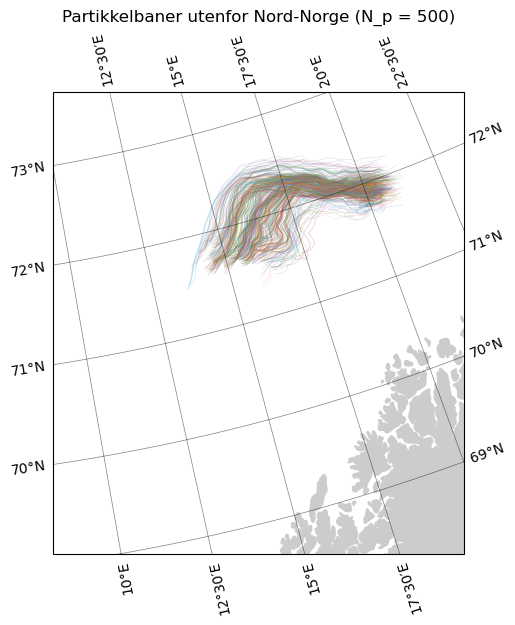

In [31]:
#plotter
N3= NormalPlot(N_p = 500, t_0 = 0, t_end =3600*24*5, h= 3600, x_expected=1_750_000, y_expected=550_000, stdx=10_000, stdy = 10_000, f=f)
fig, ax = N3.plot()
ax.set_title("Partikkelbaner utenfor Nord-Norge (N_p = 500)")
ax.set_extent((10, 20, 69, 73))
plt.show()

I dette plottet ser vi faktisk at banene ikke er like kaotiske. Dette tyder på at hastighetsfeltet til både havet og vinden varierer lite over en større romlig avstand.

Til slutt kunne det være intereressant å plotte uniformfordelte partikler utenfor Norges kystlinje. Vi valgte derfor $y_{min} = 600 000$, $y_{max} = 625 000$ og $x_{min} =  10 000$  og $x_{max} =  1 750 000$.

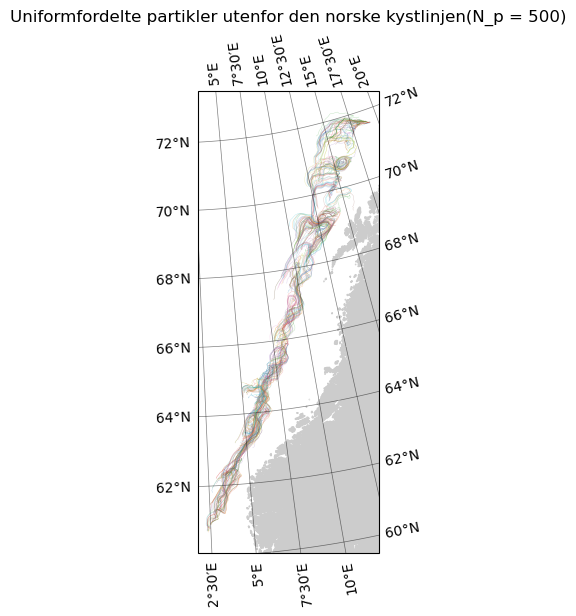

In [32]:
#plotter
N4 = UniformPlot(N_p = 500, t_0 = 0, t_end = 3600*24*5, h = 3600, startx = 300000, stopx = 1700000, starty = 595000, stopy = 600000, f=f)
fig, ax = N4.plot()
ax.set_title("Uniformfordelte partikler utenfor den norske kystlinjen(N_p = 500)")
plt.show()

Plottet over viser at det virker som om de fleste partikler i Norskehavet beveger seg inn mot landet.

#### Oppgave 3a

In [34]:
def plot_particles(Solution, f, set_extent=False, extent = [0,0,0,0]):
    #Utdelt kode
    fig = plt.figure(dpi=200)
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    npstere = ccrs.Stereographic(
        central_latitude = 90,
        central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
        false_easting = f.dataset.projection_stere.false_easting,
        false_northing = f.dataset.projection_stere.false_northing,
        true_scale_latitude = f.dataset.projection_stere.standard_parallel,
    )
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))
    # scatter plot positions, note the extra transform keyword
    x = Solution[-1,0,:]
    y = Solution[-1,1,:]
    land = f.on_land(np.array([x, y]))

    x_sea = x[land == False]
    x_land = x[land]

    y_sea = y[land  == False]
    y_land = y[land]
    ax.scatter(x_sea, y_sea, s=0.05, transform=npstere, label='På havet', color='red')
    ax.scatter(x_land, y_land, s=0.05, transform=npstere, label='På land', color='green')

    # Make outline a bit larger
    if set_extent:
        ax.set_extent((extent[0], extent[1], extent[2], extent[3]))
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )

    ax.legend()
    plt.tight_layout()
    plt.title("Strandede partikler og partikler på havet")
    plt.show()

def stranded_as_func_of_time(Solution, f):
    #Finner andelen strandet som funksjon av tiden
    def point_in_time(P):
        #Antall strandet for et tidspunkt
        return np.sum(np.where(f.on_land(np.array([P[0], P[1]])), 1, 0))
    res = np.zeros((Solution.shape[0]))
    #Finner antall strandet for alle punktene
    for i in range(len(res)):
        res[i] = point_in_time(Solution[i])
    #Deler på totalt antall for å gjøre om til andel
    res = res/Solution.shape[2]
    return res

def plot_stranded_graph(Data, label=""):
    #Plotter andelen strandet som funksjon av hvilken dag og hvilken fw
    plt.plot(np.arange(0,Data.shape[0], 1)/24,Data, label=label)
    plt.xlabel("Dager")
    plt.ylabel("Andel strandet")
    

def oppgave3(Np=10_000,fw=0.03):
    #Bruker utdelt datasett for å lage en ligning som skal løses.
    f  = Interpolator(dataset = d, fw = fw)
    X = np.zeros((2, Np))
    #Initialiserer partiklenes posisjoner
    X[0,:] = np.random.normal(loc = 250_000, scale=10_000, size = Np)
    X[1,:] = np.random.normal(loc = 460_000, scale=10_000, size = Np)
    #Tidssteg 1 time
    h = 3600
    t_0 = 0
    #Tre dager simulering
    t_end = 3*24*h
    #Løser diffligningen med Heuns metode.
    Solution = heun_method(x_0=X, t_0 = t_0, t_end = t_end, h = h, f = f)
    return Solution, f

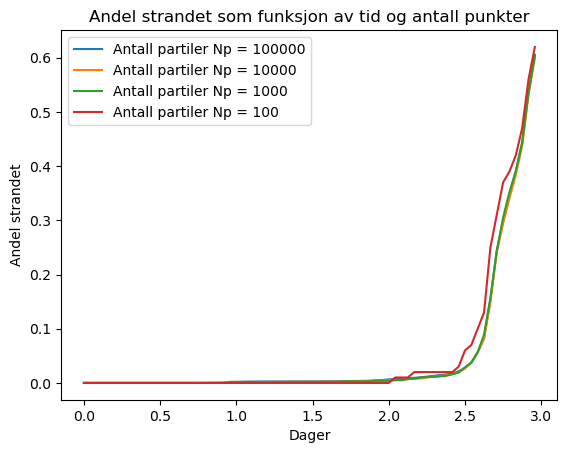

In [36]:
#Løser difflingene
Solution_arr = [[oppgave3(Np=100_000), 100_000],[oppgave3(Np=10_000), 10_000], [oppgave3(Np=1000), 1000], [oppgave3(Np=100), 100]]

#Plotter andelen strandede partikler
for e in Solution_arr:
    plot_stranded_graph(stranded_as_func_of_time(e[0][0], e[0][1]), label = "Antall partiler Np = "+str(e[1]))
plt.legend()
plt.title("Andel strandet som funksjon av tid og antall punkter")
plt.show()


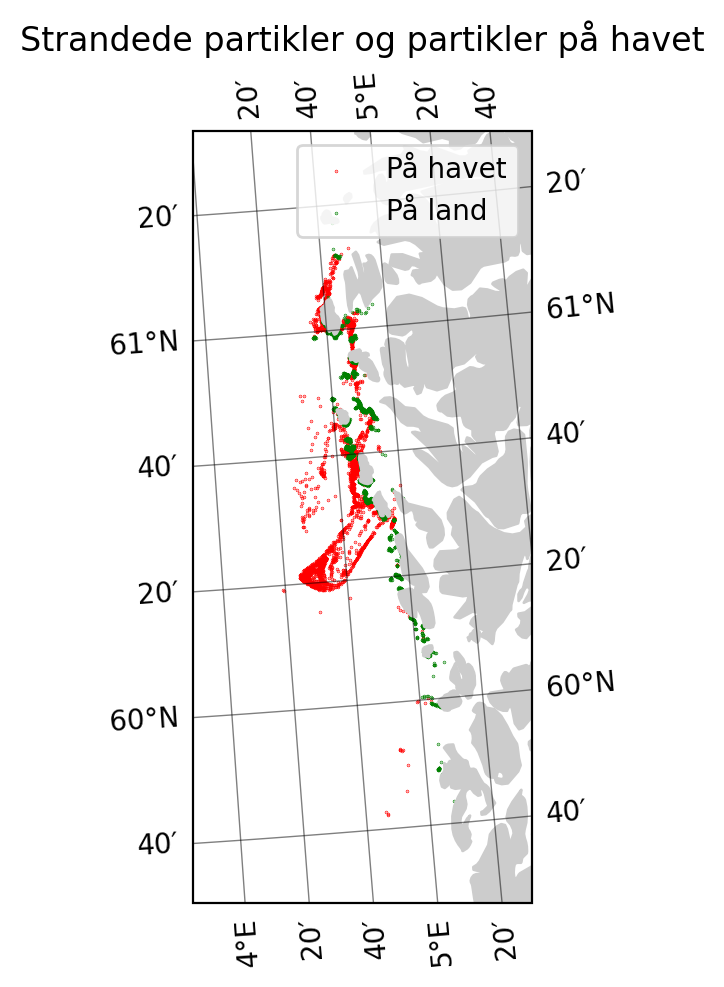

In [35]:
#Plotter strandede partikler og partikler til havs ved enden av simuleringen
plot_particles(Solution_arr[1][0][0], Solution_arr[1][0][1], set_extent=True, extent=[4, 5.5, 59.5, 61.5])


Call funksjonen i Interpolatorklassen er endret slik at et partikkel på land ikke vil bevege seg. Det implementeres ved å la hastigheten til partikkelen være 0 dersom partikkelet er på land, ved hjelp av on_land funksjonen.

Man ser at grafen for andelen strandet som funksjon av tiden er tilnærmet identisk for 100 000 og 10 000 simulerte punkter, mens den avviker noe for 1000 punkter og mye for 100 punkter. 10 000 punkter blir dermed vurdert som tilstrekkelig stort, siden et større antall simulerte punkter ikke gir synlig gevinst. Videre i oppgaven blir derfor 10 000 punker simulert.

Andelen strandet etter tre dager når windage-faktoren er 0.03 er nær 0.6, man ser at den øker med tiden, og at økningen er veldig rask, som betyr at partiklene strander omtrent samtidig.

#### Oppgave 3b

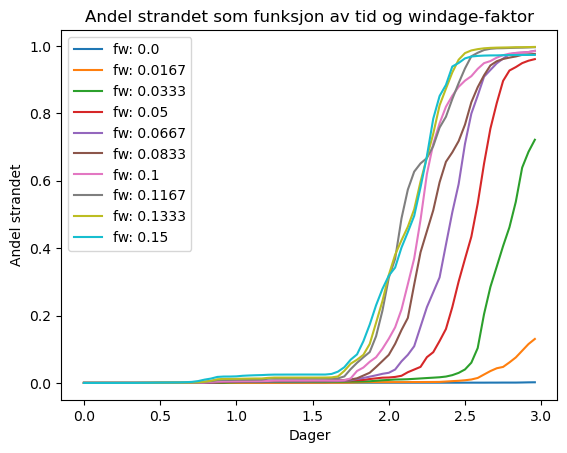

In [8]:
#Plotter andelen strandede partikler for forskjellige verdier av fw
fw_list = np.linspace(0, 0.15, 10)
for e in fw_list:
    Solution, f = oppgave3(fw=e)
    plot_stranded_graph(stranded_as_func_of_time(Solution, f), label="fw: "+str(round(e,4)))
plt.legend()
plt.title("Andel strandet som funksjon av tid og windage-faktor")
plt.show()

Når man sammenligner andelen strandet som funksjon av tiden for forskjellige windage-faktorer mellom 0 og 0.15, ser man at en høyere windage-faktor fører til at en større andel av partiklene har strandet etter 3 dager, opptil en windage-faktor på 0.05. Eksempler på dette er at omtrent 0.15 av partiklene strander med en faktor på 0.015 og omtrent 0.75 av partiklene vil strande med en windage-faktor på 0.033, mens tilnærmet alle strander med en windage-faktor på eller over 0.05. For windage-faktorer over 0.05 vil altså ikke en økende faktor føre til en økende andel strandede partikler, siden tilnærmet alle partiklene strander innenfor 3 dager uansett, men her fører høyere windage-faktor til at andelen strandede partikler øker tidligere med høyere windage-faktor, som stemmer med at en høyere windage-faktor fører til at de blåser fortere på land.

Fra plottet som viser posisjonen til strandede partikler og partikler fortsatt på havet kan man også se at de gjenværende partiklene på havet er nær de strandede partiklene, og det stemmer med at partiklene på havet ville vært strandet etter 3 døgn om windage-faktoren var høyere.

Man kan legge merke til at ingen av partiklene ender på land når windage-faktoren er 0, som betyr at havstrømmene i seg selv ikke er tilstrekkelige for å strande partikler, i dette tilfellet.

For disse initialverdiene er det åpenbart pålandsvind, og simuleringen stemmer med forventningen om at partiklene vil blåse på land, som igjen fører til at en større windage-faktor vil gjøre at partiklene raskere blåser på land. Om de blåser raskere på land vil også en større andel være strandet etter 3 dager, inntil alle er strandet etter 3 dager uansett.


### Konklusjon

I dette prosjektet modellerte vi partikkelbevegelser på Norskehavet. Vi innhentet faktiske målinger av hav- og vindhastigheter og brukte disse i modellen. Selv med vår enkle modell, så vi at små endringer i startposisjonen som regel medførte en svært ulik partikkelbane og sluttposisjon. Vi lærte også viktigheten av å velge et lite nok tidssteg fordi for store tidssteg kunne gi en annen - og dermed feil - partikkelbane. Til slutt så vi også på hvordan *windage*-faktoren påvirket andelen av partikler som strander. Vi fant at med null innflytelse av vinden strandet ingen partikler. Altså var pålandsvind i vårt tilfelle nødvendig for at partikler skal strande på land. Videre fant vi også at i vårt tilfelle vil økende *windage*-faktor øke hvor raskt partiklene strander. 